# GAN网络卡通图像生成

&#160;&#160;&#160;&#160;&#160;&#160;&#160;
本实验使用GAN网络实现卡通图像生成任务。结合课程学习，通过本实验可以了解生成对抗网络的结构和数据处理相关知识，并通过MindSpore深度学习框架实现本次实验案例：利用卡通动漫头像数据集来训练一个生成对抗的网络进而产生虚假的卡通动漫图像。

## 1、实验介绍

### 1.1 GAN网络简介

深度学习不仅在于其强大的学习能力，更在于它的创新能力。我们通过构建判别模型来提升模型的学习能力，通过构建生成模型来发挥其创新能力。判别模型通常利用训练样本训练模型,然后利用该模型，对新样本x，进行判别或预测。而生成模型正好反过来，根据一些规则y，来生成新样本x。生成式模型很多，变分自动编码器(VAE)和生成式对抗网络(GAN)及其变种。虽然两者都是生成模型，并且通过各自的生成能力展现其强大的创新能力，但他们在具体实现上有所不同，其中生成对抗网络生成效果较好。

生成对抗网络(GAN,Generative Aderversarial Networks)作为一种深度学习框架，是近几年来无监督学习方法最具前景的方法之一。2014年，lan Goodfellow发表论文《Generative Adversarial Net》首次对GAN进行了说明描述。如图所示，GAN由两个模型组成：(1)生成模型（生成器）；(2)判别模型（判别器）。在实验过程中，生成器会生成像训练图像的“高仿图像”，而判别器则需要判断生成器中的图像是否为真实图像。为了这个目的，生成器在每轮训练中会提高造假质量以生成更好的“假图像”来骗过判别器。判别器也需要提升判别能力来分辨是否造假。这形成了一种博弈，博弈的平衡点就是生成器生成的图像非常真实，二判别器判别概率为50%。

<img src="./images/total.png">

### 1.2 选择实验环境

运行下面代码，在改变`token`的值来选择实验环境，目前支持CPU和Ascend NPU切换。

In [1]:
import os
import mindspore
from mindspore import context
import ipywidgets as wgs # 控件

dropdown = wgs.Dropdown(description="Select Device", options=['Click to choose', 'CPU', 'Ascend NPU'])
output = wgs.Output()
def changeDevice(change):
    output.clear_output()
    #device_id = 2
    token = change.new
    with output:
        if token == 'Click to choose':
            print("请选择运行环境")
        if token == 'CPU':
            print("请确认当前环境为CPU\n======================================================================")
            try:
                context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
                print("已检查！确认当前环境为CPU")
            except ValueError:
                print("错误！当前是系统硬件不是CPU，请重新选择合适的硬件设备")
        if token == 'Ascend NPU':
            print("请确认当前环境为Ascend NPU\n===============================================================")
            try:
                context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)
                print("当前环境为Ascend NPU")
            except ValueError:
                print("错误！当前是系统硬件不是Ascend NPU，请重新选择合适的硬件设备")


dropdown.observe(changeDevice, names='value')
display(dropdown, output)

Dropdown(description='Select Device', options=('Click to choose', 'CPU', 'Ascend NPU'), value='Click to choose…

Output()

运行下面代码继续完成硬件平台配置

In [2]:
# 参数设置
mindspore.set_seed(1)
data_root = "./dataset/data"  # 数据集根目录
workers = 4  # 载入数据线程数
batch_size = 128  # 批量大小
image_size = 64  # 训练图像空间大小，所有图像都将调整为该大小
nc = 3  # 图像彩色通道数，对于彩色图像为3
nz = 100  # 隐向量的长度
ngf = 64  # 特征图在生成器中的大小
ndf = 64  # 特征图在判别器中的大小
num_epochs = 1  # 训练周期数
lr = 0.0002  # 学习率
beta1 = 0.5  # Adam优化器的beta1超参数
# 运行硬件设置
if dropdown.value == 'CPU':
    print("选择的环境是：" + dropdown.value)
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
        print("CPU环境设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持CPU，请返回上一步重新选择合适的硬件设备")
elif dropdown.value == 'Ascend NPU':
    print("选择的环境是：" + dropdown.value)
    device_id = 0
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)
        import moxing
        import argparse
        import os
        # 定义目录
        parser = argparse.ArgumentParser()
        parser.add_argument('--data_url', required=False, default='minist/', help='Location of data.')
        parser.add_argument('--train_url', required=False, default=None, help='Location of training outputs.')
        args, unknown = parser.parse_known_args()

        if args.data_url.startswith('s3'):

            moxing.file.copy_parallel(src_url=args.data_url, dst_url='minist/')

            data_path = 'minist/'
        else:
            data_path = os.path.abspath(args.data_url)
        print("Ascend NPU环境设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持Asend NPU，请返回上一步重新选择合适的硬件设备")

选择的环境是：CPU
CPU环境设置成功！


## 2、数据集加载

### 2.1 数据集准备

在本次实验中，将使用动漫头像数据集，该数据集包含21551张各式各样的卡通动漫头像，如图1所示。每张图像大小为64×64。为了使程序运行流畅，本次实验在当前路径下创建一个data目录，并在此目录下创建一个名为train的子目录。

<img src="./images/picface.png">

数据集的目录结构为：
<br/>
.\data
<br/>
└─train
<br/>
......
<br/>
10001.png
<br/>
10002.png
<br/>
10003.png
<br/>
10004.png
<br/>
......

In [3]:
import os
import requests
import time
import zipfile

# 自动下载并解压数据集到指定文件夹内
def download_and_unzip(url, path):
    if not os.path.exists(path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(path)
    file_path = os.path.join(path, 'data.zip')
    start = time.time() #下载开始时间
    user, password = 'tyx_neu', 'Sportlab307'
    resp = requests.get(url, auth=(user, password), stream=True)      #把下载地址发送给requests模块
    size = 0    #初始化已下载大小
    chunk_size = 1024  # 每次下载的数据大小
    content_size = int(resp.headers['content-length'])  # 下载文件总大小
    try:
        if resp.status_code == 200:   #判断是否响应成功
            print('Start download,[File size]:{size:.2f} MB'.format(size=content_size/chunk_size/1024))   #开始下载，显示下载文件大小
            with open(file_path, 'wb') as file:   #显示进度条
                for data in resp.iter_content(chunk_size=chunk_size):
                    file.write(data)
                    size += len(data)
                    print('\r'+'[下载进度]:%s%.2f%%' % ('>'*int(size*50/content_size), float(size/content_size*100)), end=' ')
        end = time.time()   #下载结束时间
        print('\n'+'Download completed!,times: %.2f秒' % (end - start))  #输出下载用时时间
    except ValueError:
        print('Error!')
    #unzip_file_path = os.path.join(path, 'data')
    unzip_file_path = path
    if not os.path.exists(unzip_file_path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(unzip_file_path)
    zip_file = zipfile.ZipFile(file_path)
    zip_list = zip_file.namelist()  # 压缩文件清单，可以直接看到压缩包内的各个文件的明细
    for f in zip_list:  # 遍历这些文件，逐个解压出来，
        zip_file.extract(f, unzip_file_path)
    zip_file.close()
    print('Successfully unzip download dataset from website!')

#下载地址
url = 'https://openi.pcl.ac.cn/attachments/427e823f-ab52-45a7-9f43-98371c7d5b1e?type=0'
download_and_unzip(url, os.path.join(os.getcwd(), 'dataset'))

Start download,[File size]:220.31 MB
[下载进度]:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00% 
Download completed!,times: 128.79秒
Successfully unzip download dataset from website!


### 2.2 数据集加载

本次实验案例需在CPU和华为云NPU进行运行，所以应根据要求分别运行后续代码（只运行一个代码块）。

使用GRAPH的模式运行实验，并对相关参数进行定义。

#### 2.2.1 数据预处理

自定义函数create_dataset_imagenet对数据进行处理和增强

In [3]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as vision

def create_dataset_imagenet(dataset_path, num_parallel_workers=None):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path, num_parallel_workers=num_parallel_workers, shuffle=True,
                                     decode=True)

    # 数据增强操作
    transform_img = [
        vision.Resize(image_size),
        vision.CenterCrop(image_size),
        vision.HWC2CHW(),
        lambda x: ((x / 255).astype("float32"), np.random.normal(size=(nz, 1, 1)).astype("float32"))
    ]

    # 数据映射操作
    data_set = data_set.map(input_columns="image", num_parallel_workers=num_parallel_workers, operations=transform_img,
                            output_columns=["image", "latent_code"], column_order=["image", "latent_code"])

    # 批量操作
    data_set = data_set.batch(batch_size)
    return data_set

# 获取处理后的数据集
data = create_dataset_imagenet(data_root, num_parallel_workers=workers)

# 获取数据集大小
size = data.get_dataset_size()
print(size)

169


#### 2.2.2 数据集可视化

对数据集图像进行可视化操作

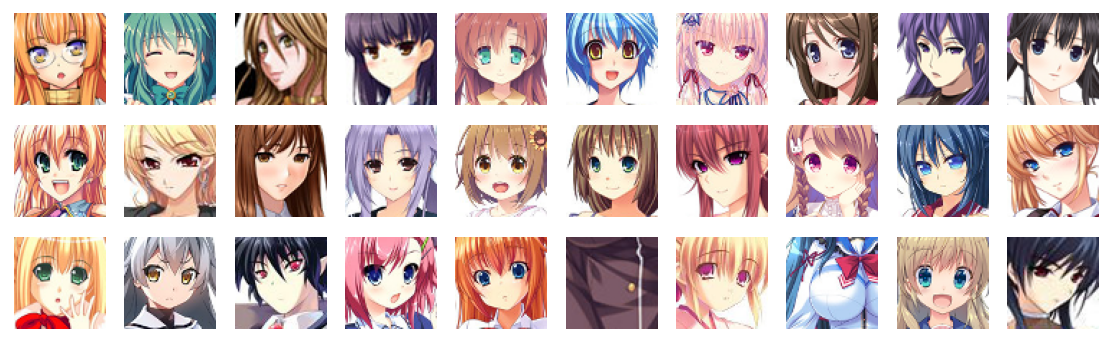

In [4]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(data.create_dict_iterator(output_numpy=True))

# 可视化部分训练数据
plt.figure(figsize=(10, 3), dpi=140)
for i, image in enumerate(data_iter['image'][:30], 1):
    plt.subplot(3, 10, i)
    plt.axis("off")
    plt.imshow(image.transpose(1, 2, 0))
plt.show()

## 3、判别器与生成器模型建立

处理数据后，需搭建GAN的网络模型，本节分别从权重初始化出发，搭建生成器、判别器和损失函数模型。

### 3.1 生成器模型

生成器G通过图像反卷积操作将噪声图像生成目标图像，最后通过判别器来评估其接近真实图像的程度，生成器结构如图所示

<img src="./images/G.png">

生成器模型建立的代码如下

In [8]:
from mindspore import nn
from mindspore.common.initializer import Normal
from mindspore import load_checkpoint

def conv_t(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    """定义转置卷积层"""
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2dTranspose(in_channels, out_channels,
                              kernel_size=kernel_size, stride=stride, padding=padding,
                              weight_init=weight_init, has_bias=False, pad_mode=pad_mode)

def bn(num_features):
    """定义BatchNorm2d层"""
    gamma_init = Normal(mean=1, sigma=0.02)
    return nn.BatchNorm2d(num_features=num_features, gamma_init=gamma_init)

class Generator(nn.Cell):
    """DCGAN网络生成器"""

    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.SequentialCell()
        self.generator.append(conv_t(nz, ngf * 8, 4, 1, 0))
        self.generator.append(bn(ngf * 8))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 8, ngf * 4, 4, 2, 1))
        self.generator.append(bn(ngf * 4))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 4, ngf * 2, 4, 2, 1))
        self.generator.append(bn(ngf * 2))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 2, ngf, 4, 2, 1))
        self.generator.append(bn(ngf))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf, nc, 4, 2, 1))
        self.generator.append(nn.Tanh())

    def construct(self, x):
        return self.generator(x)

# 实例化生成器
netG = Generator()
param_dict_G = load_checkpoint("./checkpoints/Generator.ckpt", netG)
print(netG)

[WARNING] ME(29908:12008,MainProcess):2023-01-06-15:24:29.666.656 [mindspore\train\serialization.py:674] For 'load_param_into_net', remove parameter myTrainOneStepCellForG.netG.generator.0.weight's prefix name: myTrainOneStepCellForG.netG.generator., continue to load it to net parameter 0.weight.
[WARNING] ME(29908:12008,MainProcess):2023-01-06-15:24:29.673.654 [mindspore\train\serialization.py:674] For 'load_param_into_net', remove parameter myTrainOneStepCellForG.network.netG.generator.1.moving_mean's prefix name: myTrainOneStepCellForG.network.netG.generator., continue to load it to net parameter 1.moving_mean.


Generator<
  (generator): SequentialCell<
    (0): Conv2dTranspose<input_channels=100, output_channels=512, kernel_size=(4, 4), stride=(1, 1), pad_mode=pad, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.Normal object at 0x000001F1FA086808>, bias_init=zeros>
    (1): BatchNorm2d<num_features=512, eps=1e-05, momentum=0.09999999999999998, gamma=Parameter (name=1.gamma, shape=(512,), dtype=Float32, requires_grad=True), beta=Parameter (name=1.beta, shape=(512,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=1.moving_mean, shape=(512,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=1.moving_variance, shape=(512,), dtype=Float32, requires_grad=False)>
    (2): ReLU<>
    (3): Conv2dTranspose<input_channels=512, output_channels=256, kernel_size=(4, 4), stride=(2, 2), pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.Normal object at 0x000001F1FA08

### 3.2 判别器模型

判别器对生成器生成的图像进行判别，最终输出一个概率值来判断是否为真实图像。其结构如图所示

<img src="./images/D.png">

判别器模型建立的代码如下

In [10]:
from mindspore import nn
from mindspore.common.initializer import Normal
from mindspore import load_checkpoint

def conv(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    """定义卷积层"""
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight_init, has_bias=False, pad_mode=pad_mode)

class Discriminator(nn.Cell):
    """DCGAN网络判别器"""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.SequentialCell()
        self.discriminator.append(conv(nc, ndf, 4, 2, 1))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf, ndf * 2, 4, 2, 1))
        self.discriminator.append(bn(ndf * 2))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 2, ndf * 4, 4, 2, 1))
        self.discriminator.append(bn(ndf * 4))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 4, ndf * 8, 4, 2, 1))
        self.discriminator.append(bn(ndf * 8))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 8, 1, 4, 1))
        self.discriminator.append(nn.Sigmoid())

    def construct(self, x):
        return self.discriminator(x)

# 实例化判别器
netD = Discriminator()
param_dict_D = load_checkpoint("./checkpoints/Discriminator.ckpt", netD)
print(netD)

[WARNING] ME(29908:12008,MainProcess):2023-01-06-15:25:09.529.749 [mindspore\train\serialization.py:674] For 'load_param_into_net', remove parameter myTrainOneStepCellForG.network.netD.discriminator.0.weight's prefix name: myTrainOneStepCellForG.network.netD.discriminator., continue to load it to net parameter 0.weight.


Discriminator<
  (discriminator): SequentialCell<
    (0): Conv2d<input_channels=3, output_channels=64, kernel_size=(4, 4), stride=(2, 2), pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.Normal object at 0x000001F1FA08FC08>, bias_init=zeros, format=NCHW>
    (1): LeakyReLU<>
    (2): Conv2d<input_channels=64, output_channels=128, kernel_size=(4, 4), stride=(2, 2), pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.Normal object at 0x000001F1FA0902C8>, bias_init=zeros, format=NCHW>
    (3): BatchNorm2d<num_features=128, eps=1e-05, momentum=0.09999999999999998, gamma=Parameter (name=3.gamma, shape=(128,), dtype=Float32, requires_grad=True), beta=Parameter (name=3.beta, shape=(128,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=3.moving_mean, shape=(128,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=3.moving_variance, shape=(128

### 3.3 损失函数与优化器创建

在建立了生成器和判别器的训练模型之后，接下来使用Mindspore定义损失函数和优化器。

In [11]:
from mindspore import Tensor
from mindspore import dtype as mstype

# 定义损失函数
criterion = nn.BCELoss(reduction='mean')

# 创建一批隐向量用来观察G
np.random.seed(1)
fixed_noise = Tensor(np.random.randn(64, nz, 1, 1), dtype=mstype.float32)

# 重新定义优化器函数
optimizerD = nn.Adam(netD.trainable_params(), learning_rate=lr, beta1=beta1)
optimizerG = nn.Adam(netG.trainable_params(), learning_rate=lr, beta1=beta1)

我们接下来定义两个类来连接网络和损失函数。Mindspore将损失函数和优化器都封装到了Cell中，由于GAN结构比较特殊，导致它和一般的分类网络不同，因此我们需要自定义WithLossCell类，起到连接网络和Loss的作用。代码如下

In [12]:
class WithLossCellG(nn.Cell):
    """连接生成器和损失"""

    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellG, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, latent_code):
        """构建生成器损失计算结构"""
        fake_data = self.netG(latent_code)
        out = self.netD(fake_data)
        label_real = ops.OnesLike()(out)
        loss = self.loss_fn(out, label_real)
        return loss

class WithLossCellD(nn.Cell):
    """连接判别器和损失"""

    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellD, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, real_data, latent_code):
        """构建判别器损失计算结构"""
        out_real = self.netD(real_data)
        label_real = ops.OnesLike()(out_real)
        loss_real = self.loss_fn(out_real, label_real)

        fake_data = self.netG(latent_code)
        fake_data = ops.stop_gradient(fake_data)
        out_fake = self.netD(fake_data)
        label_fake = ops.ZerosLike()(out_fake)
        loss_fake = self.loss_fn(out_fake, label_fake)
        return loss_real + loss_fake

## 4 GAN模型训练

### 4.1 定义网络

通过建立DCGAN(nn.Cell)类，为网络实例化做基础。

In [13]:
class DCGAN(nn.Cell):
    """定义DCGAN网络"""

    def __init__(self, myTrainOneStepCellForD, myTrainOneStepCellForG):
        super(DCGAN, self).__init__(auto_prefix=True)
        self.myTrainOneStepCellForD = myTrainOneStepCellForD
        self.myTrainOneStepCellForG = myTrainOneStepCellForG

    def construct(self, real_data, latent_code):
        output_D = self.myTrainOneStepCellForD(real_data, latent_code).view(-1)
        netD_loss = output_D.mean()
        output_G = self.myTrainOneStepCellForG(latent_code).view(-1)
        netG_loss = output_G.mean()
        return netD_loss, netG_loss

# 实例化WithLossCell
netD_with_criterion = WithLossCellD(netD, netG, criterion)
netG_with_criterion = WithLossCellG(netD, netG, criterion)

# 实例化TrainOneStepCell
myTrainOneStepCellForD = nn.TrainOneStepCell(netD_with_criterion, optimizerD)
myTrainOneStepCellForG = nn.TrainOneStepCell(netG_with_criterion, optimizerG)

实例化GAN网络，并对网络进行循环训练。

In [14]:
from mindspore import ops
from mindspore import save_checkpoint

# 实例化DCGAN网络
dcgan = DCGAN(myTrainOneStepCellForD, myTrainOneStepCellForG)

dcgan.set_train()

# 创建迭代器
data_loader = data.create_dict_iterator(output_numpy=True, num_epochs=num_epochs)
G_losses = []
D_losses = []
image_list = []

# 开始循环训练
print("Starting Training Loop...")

for epoch in range(num_epochs):
    # 为每轮训练读入数据
    for i, d in enumerate(data_loader):
        real_data = Tensor(d['image'])
        latent_code = Tensor(d["latent_code"])
        netD_loss, netG_loss = dcgan(real_data, latent_code)
        if i % 50 == 0 or i == size - 1:
            # 输出训练记录
            print('[%2d/%d][%3d/%d]   Loss_D:%7.4f  Loss_G:%7.4f' % (
                epoch + 1, num_epochs, i + 1, size, netD_loss.asnumpy(), netG_loss.asnumpy()))
        D_losses.append(netD_loss.asnumpy())
        G_losses.append(netG_loss.asnumpy())

    # 每个epoch结束后，使用生成器生成一组图片
    img = netG(fixed_noise)
    image_list.append(img.transpose(0, 2, 3, 1).asnumpy())

# 保存网络模型参数为ckpt文件
save_checkpoint(netG, "./checkpoints/Generator_F.ckpt")
save_checkpoint(netD, "./checkpoints/Discriminator_F.ckpt")

Starting Training Loop...
[ 1/1][  1/169]   Loss_D: 0.8760  Loss_G: 0.8902
[ 1/1][ 51/169]   Loss_D: 0.2721  Loss_G: 3.3538
[ 1/1][101/169]   Loss_D: 1.3791  Loss_G: 5.8140
[ 1/1][151/169]   Loss_D: 0.8454  Loss_G: 3.0283
[ 1/1][169/169]   Loss_D: 1.4197  Loss_G: 5.5720


### 4.2 可视化结果验证

运行下面代码，描述生成器和判别器的损失训练迭代关系图

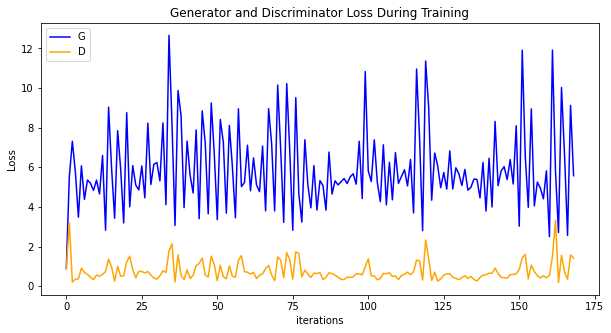

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G", color='blue')
plt.plot(D_losses, label="D", color='orange')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

生成卡通头像

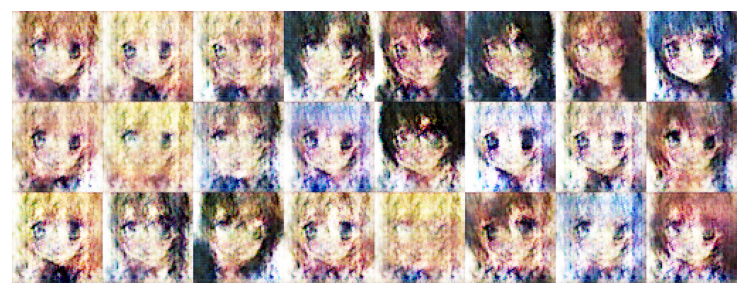

In [19]:
from mindspore import load_checkpoint

# 从文件中获取模型参数并加载到网络中
param_dict = load_checkpoint("./checkpoints/Generator_F.ckpt", netG)

img64 = netG(fixed_noise).transpose(0, 2, 3, 1).asnumpy()

fig = plt.figure(figsize=(8, 3), dpi=120)
images = []
for i in range(3):
    images.append(np.concatenate((img64[i * 8:(i + 1) * 8]), axis=1))
img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
plt.axis("off")
plt.imshow(img)
plt.show()

## 5、实验任务

### 5.1 生成器模型实验任务

请同学们利用图像反卷积编码构建生成器神经网络，网络包括5个反卷积层，4个Relu()激活函数。最后以1个Tanh()激活函数作为输出，最终生成144维图像

### 5.2 判别器模型实验任务

请同学们利用图像卷积编码构建判别器神经网络，网络包括5个卷积层，4个LeakRelu()激活函数。最后以1个SIgmoid()激活函数作为输出，得到1维判别概率